Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libzbar0 is already the newest version (0.23.92-4build2).
tesseract-ocr is already the newest version (4.1.1-2.1build1).
tesseract-ocr-eng is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


Saving IMG_0254.jpeg to IMG_0254.jpeg
✔ تم رفع الصورة: IMG_0254.jpeg
 تم قص اللوحة   plate_crop.jpg


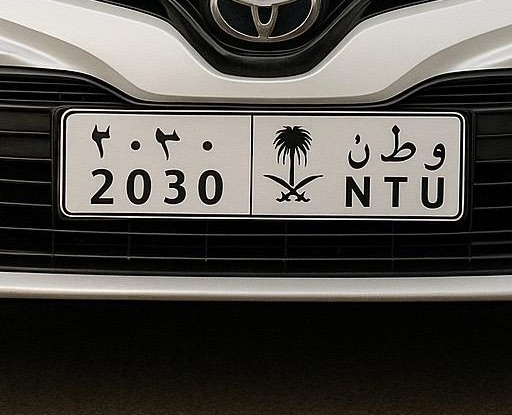


----- OCR RAW -----
'ON QT V\n2030NTU\n\x0c'
----- OCR CLEAN ---
ON QT V
2030NTU
----- OCR PLATE ---
2030NTU
-------------------

📌 اللوحة الرسمية : 2030NTU
📌 بعد التطبيع    : 2030NTU

🔐 Encrypted (Base64)   : f0lgVS0mMA==
🧩 Decrypted RAW        : '2030NTU'
🧩 Decrypted Normalized : 2030NTU

✅ تم إنشاء كود QR في الملف: vehicle_qr.png


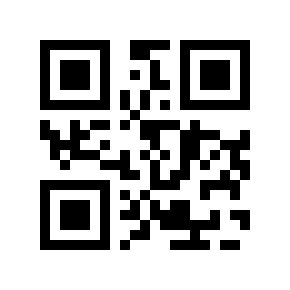


📦 النص من الباركود RAW        : '2030NTU'
📦 النص من الباركود Normalized : 2030NTU
-------------------------------------------------------------
✅ تطابق تام بين:
   • رقم اللوحة المقروء من الصورة (OCR)
   • رقم اللوحة داخل الباركود (QR)
   • رقم اللوحة الرسمي في النظام (2030NTU)
ℹ️ لا يتم اتخاذ أي إجراء. (سيارة سليمة).


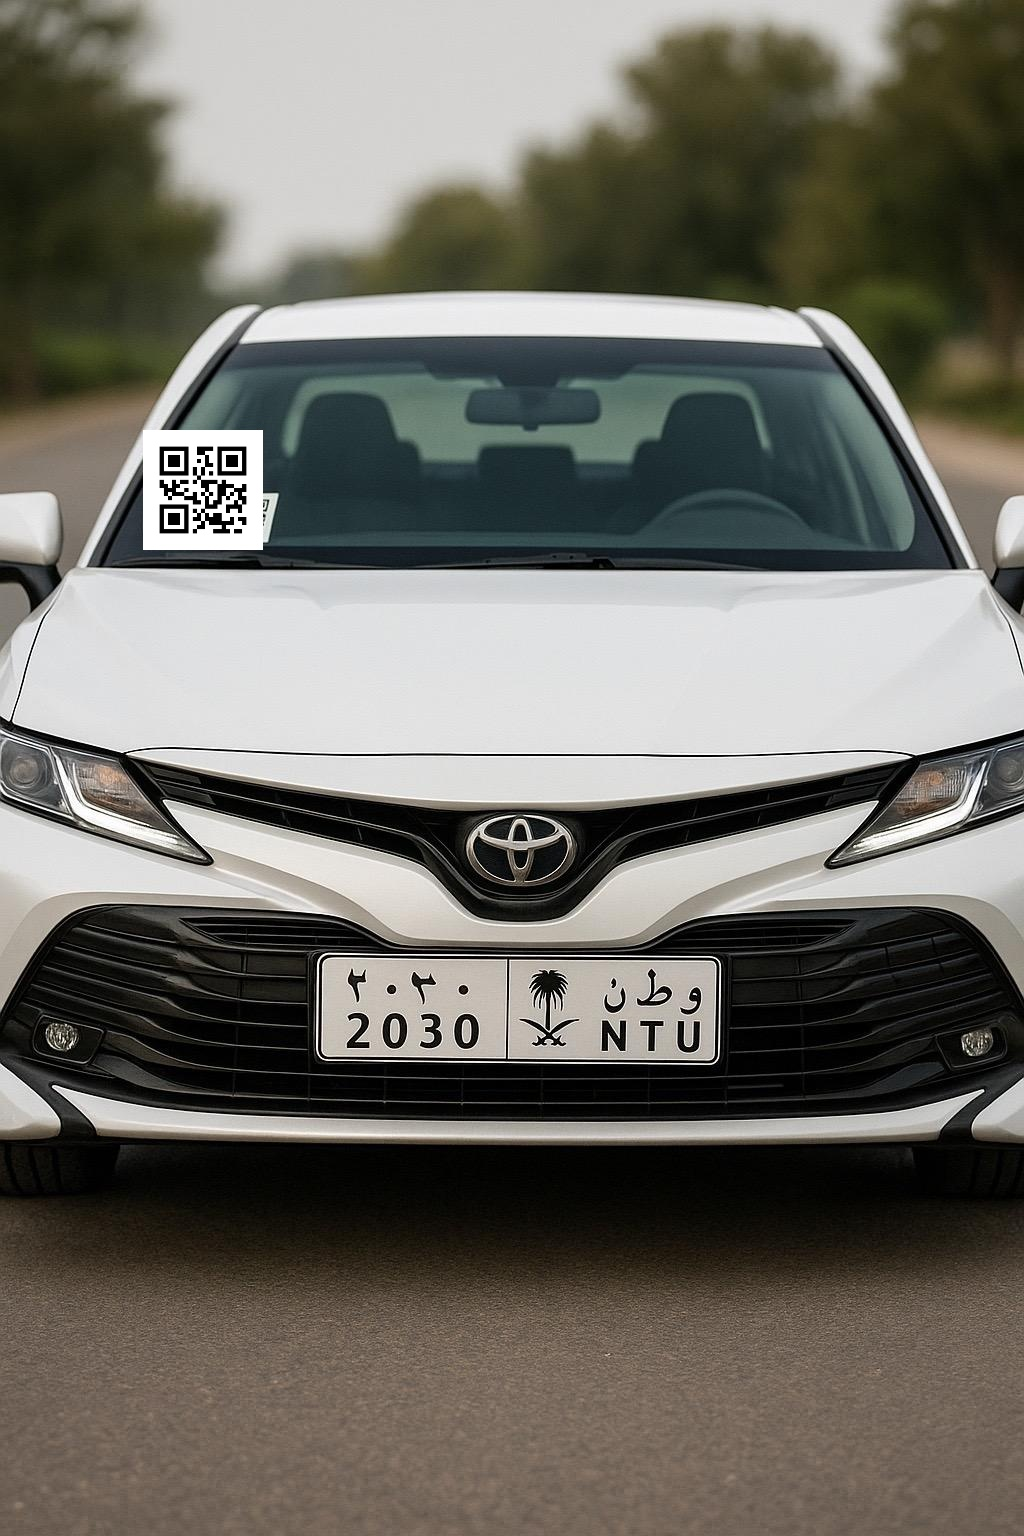

In [ ]:
# OCR + QR Comparison + XOR Encryption + Traffic Alert


!pip install qrcode[pil] pyzbar pytesseract pillow opencv-python-headless
!apt-get install -y tesseract-ocr tesseract-ocr-eng libzbar0

import base64, qrcode, cv2, pytesseract, re
from PIL import Image
from google.colab import files
from pyzbar.pyzbar import decode

try:
    from IPython.display import display
except ImportError:
    display = None


# XOR Encryption / Decryption

def xor_encrypt(text: str, key: str) -> bytes:
    encrypted_bytes = bytearray()
    for i, ch in enumerate(text):
        encrypted_bytes.append(ord(ch) ^ ord(key[i % len(key)]))
    return bytes(encrypted_bytes)

def xor_decrypt(cipher_bytes: bytes, key: str) -> str:
    chars = []
    for i, b in enumerate(cipher_bytes):
        chars.append(chr(b ^ ord(key[i % len(key)])))
    return "".join(chars)


#  توحيد شكل النص

def normalize_plate(text: str) -> str:
    if text is None:
        return ""
    text = text.upper()
    text = text.strip()
    # نسمح فقط بالحروف والأرقام
    text = re.sub(r'[^A-Z0-9]', '', text)
    return text


def extract_plate(text: str) -> str:
    norm = normalize_plate(text)
    # نبحث عن 4 أرقام ثم 3 حروف A-Z
    m = re.search(r'(\d{4}[A-Z]{3})', norm)
    if m:
        return m.group(1)
    return norm


#  رفع صورة السيارة

uploaded = files.upload()
image_name = list(uploaded.keys())[0]
print("✔ تم رفع الصورة:", image_name)

img = cv2.imread(image_name)
h, w, _ = img.shape

# قص منطقة اللوحة (حسب نسب الصورة عندك)
y1, y2 = int(h * 0.55), int(h * 0.82)
x1, x2 = int(w * 0.25), int(w * 0.75)

plate = img[y1:y2, x1:x2]
cv2.imwrite("plate_crop.jpg", plate)
print(" تم قص اللوحة   plate_crop.jpg")
if display:
    display(Image.open("plate_crop.jpg"))


#  قراءة اللوحة بالـ OCR

gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 11, 17, 17)

custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
ocr_text_raw = pytesseract.image_to_string(gray, lang='eng', config=custom_config)

ocr_text_clean = ocr_text_raw.strip().upper()
ocr_plate = extract_plate(ocr_text_raw)

print("\n----- OCR RAW -----")
print(repr(ocr_text_raw))
print("----- OCR CLEAN ---")
print(ocr_text_clean)
print("----- OCR PLATE ---")
print(ocr_plate)
print("-------------------")

if not ocr_plate:
    raise ValueError("❌ لم يتم استخراج رقم لوحة صالح من الصورة. تأكد من وضوح اللوحة.")


#  اللوحة الرسمية المسجلة في النظام

official_plate = "2030NTU"
official_plate_norm = normalize_plate(official_plate)

print("\n📌 اللوحة الرسمية :", official_plate)
print("📌 بعد التطبيع    :", official_plate_norm)

secret_key = "MySecretKey"


#  تشفير اللوحة الرسمية و إنشاء QR

encrypted_bytes = xor_encrypt(official_plate_norm, secret_key)
encrypted_base64 = base64.b64encode(encrypted_bytes).decode("utf-8")

decoded_bytes = base64.b64decode(encrypted_base64)
decrypted_text_raw = xor_decrypt(decoded_bytes, secret_key)
decrypted_text_norm = normalize_plate(decrypted_text_raw)

print("\n🔐 Encrypted (Base64)   :", encrypted_base64)
print("🧩 Decrypted RAW        :", repr(decrypted_text_raw))
print("🧩 Decrypted Normalized :", decrypted_text_norm)

qr_filename = "vehicle_qr.png"
qr = qrcode.QRCode(box_size=10, border=4)
qr.add_data(encrypted_base64)
qr.make(fit=True)
qr.make_image(fill_color="black", back_color="white").save(qr_filename)

print(f"\n✅ تم إنشاء كود QR في الملف: {qr_filename}")
if display:
    display(Image.open(qr_filename))


#  قراءة الـ QR والمقارنة

decoded_qr = decode(Image.open(qr_filename))
if decoded_qr:
    qr_data = decoded_qr[0].data.decode('utf-8')
    qr_decoded_bytes = base64.b64decode(qr_data)
    qr_decrypted_raw = xor_decrypt(qr_decoded_bytes, secret_key)
    qr_decrypted_norm = normalize_plate(qr_decrypted_raw)

    print("\n📦 النص من الباركود RAW        :", repr(qr_decrypted_raw))
    print("📦 النص من الباركود Normalized :", qr_decrypted_norm)
    print("-------------------------------------------------------------")


    ocr_plate_norm = normalize_plate(ocr_plate)

    if ocr_plate_norm == qr_decrypted_norm == official_plate_norm:
        print("✅ تطابق تام بين:")
        print("   • رقم اللوحة المقروء من الصورة (OCR)")
        print("   • رقم اللوحة داخل الباركود (QR)")
        print("   • رقم اللوحة الرسمي في النظام (2030NTU)")
        print("ℹ️ لا يتم اتخاذ أي إجراء. (سيارة سليمة).")
    else:
        print("❌ اختلاف بين رقم اللوحة والبيانات داخل الباركود !")
        print(f"   رقم اللوحة من OCR (بعد الاستخراج): {ocr_plate_norm}")
        print(f"   رقم اللوحة من الباركود            : {qr_decrypted_norm}")
        print(f"   رقم اللوحة الرسمية في النظام      : {official_plate_norm}")
        print("🚨🚨 إرسال إشعار فوري إلى  المرور:       .")
else:
    print("⚠️ لم يتم قراءة كود QR من الصورة.")




base_img = cv2.imread(image_name)
qr_img = cv2.imread(qr_filename)

qr_size = 120
qr_img = cv2.resize(qr_img, (qr_size, qr_size))

y_offset = int(h * 0.28)
x_offset = int(w * 0.14)

y1, y2 = y_offset, y_offset + qr_img.shape[0]
x1, x2 = x_offset, x_offset + qr_img.shape[1]

base_img[y1:y2, x1:x2] = qr_img

final_image_name = "car_with_new_qr.jpg"
cv2.imwrite(final_image_name, base_img)

if display:
    display(Image.open(final_image_name))